In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torch.utils.data import TensorDataset,DataLoader

In [2]:
# Download dataset
orig_train_set = datasets.MNIST('data/',train=True,download=True)
orig_test_set = datasets.MNIST('data/',train=False,download=True)

In [3]:
# Tensor data into arrays

orig_train_data = orig_train_set.data.numpy()
orig_test_data = orig_test_set.data.numpy()
orig_train_labels = orig_train_set.targets.numpy()
orig_test_labels = orig_test_set.targets.numpy()

In [4]:
# Data creation for Segmentation 

orig_image_size = 28
num_train_data = 500
num_valid_data = 50
num_test_data = 25
seg_image_size = 128
num_search_spot_iter = 250


def seg_data_creation(num_seg_data=5250,seg_image_size=128,num_digits=9,from_train=True):
    seg_images = np.zeros([num_seg_data,seg_image_size,seg_image_size],np.float32)
    seg_labels = np.empty([num_seg_data,seg_image_size,seg_image_size],np.float32)
    seg_labels.fill(10)#10 for background class
    if from_train:
        source_data = orig_train_data
        source_labels = orig_train_labels
    else:
        source_data = orig_test_data
        source_labels = orig_test_labels
    print('Generating {number} images...'.format(number=num_seg_data))
    for seg_image,seg_label in zip(seg_images,seg_labels):
        for n in range(num_digits):
            data_index = np.random.randint(0,len(source_data))
            orig_image = source_data[data_index].reshape(orig_image_size,orig_image_size)
            orig_label = source_labels[data_index]
            orig_seg_label = np.empty([orig_image_size,orig_image_size],np.float32)
            orig_seg_label.fill(10)
            orig_seg_label[np.where(orig_image>0)] = orig_label
            for i in range(num_search_spot_iter):
                x_pos = np.random.randint(0,seg_image_size-orig_image_size)
                y_pos = np.random.randint(0,seg_image_size-orig_image_size)
                if seg_image[x_pos:x_pos+orig_image_size,y_pos:y_pos+orig_image_size].sum()==0:
                    seg_image[x_pos:x_pos+orig_image_size,y_pos:y_pos+orig_image_size] = orig_image
                    seg_label[x_pos:x_pos+orig_image_size,y_pos:y_pos+orig_image_size] = orig_seg_label
                    break
    print('Done!')
    return seg_images,seg_labels


train_seg_images,train_seg_labels = seg_data_creation(num_train_data,128,9,True)
valid_seg_images,valid_seg_labels = seg_data_creation(num_valid_data,128,9,True) 
test_seg_images,test_seg_labels = seg_data_creation(num_test_data,128,9,False) 

Generating 500 images...
Done!
Generating 50 images...
Done!
Generating 25 images...
Done!


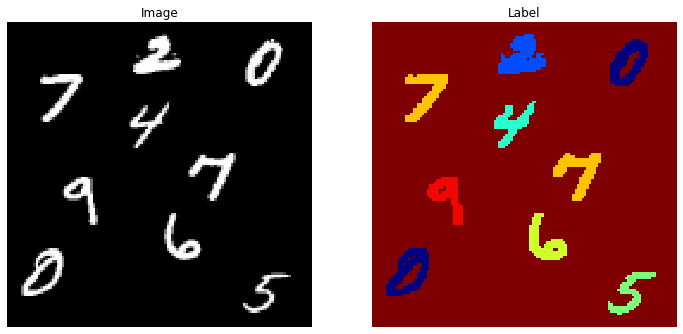

In [5]:
# Visualize segmentation data

viz_idx = 150
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.imshow(train_seg_images[viz_idx],cmap='gray')
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(train_seg_labels[viz_idx],cmap='jet')
ax2.set_title('Label')
ax2.axis('off')
plt.show()

In [6]:
# Create Dataloaders

traindataset = TensorDataset(torch.from_numpy(train_seg_images),torch.from_numpy(train_seg_labels))
validdataset = TensorDataset(torch.from_numpy(valid_seg_images),torch.from_numpy(valid_seg_labels))
testdataset = TensorDataset(torch.from_numpy(test_seg_images),torch.from_numpy(test_seg_labels))

train_valid_batchsize = 12
test_batchsize = 1
num_workers = 1

train_dataloader = DataLoader(traindataset,batch_size=train_valid_batchsize,shuffle=True,num_workers=num_workers)
valid_dataloader = DataLoader(validdataset,batch_size=train_valid_batchsize,shuffle=True,num_workers=num_workers)
test_dataloader = DataLoader(testdataset,batch_size=test_batchsize,shuffle=True,num_workers=num_workers)

In [7]:
# Model - UNET Architecture

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )   

def upsample_conv(in_channels):
    return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)

class UNet_Mnist(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class,1, stride=1)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def upsample_conv(in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2, padding=0)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        x = self.dconv_down4(x)
        
        x = self.upsample(x)   
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        x = self.conv_last(x)
        out = self.softmax(x)
        
        return out

In [8]:
# Set device

if torch.cuda.is_available():
    print('GPU available')
    device='cuda'
else:
    print('GPU not available')
    device='cpu'
    
num_classes = 11 #10 digits and background
    
model = UNet_Mnist(num_classes).to(device)

GPU available


In [9]:
# Loss

def label_split(labels,targetimage,n_class):
    for i in range(n_class):
        labels[:,i,:,:][targetimage==i] = 1
    return labels

def calc_loss(pred,target,num_classes):
    label_ph = torch.zeros_like(pred)
    label = label_split(label_ph,target,num_classes)
    bce_loss = F.binary_cross_entropy_with_logits(pred, label)
    return bce_loss

In [10]:
# Train and validate

def train(train_dataloader,model,optimizer,device):
    total_train_loss = 0
    for i,(x,y) in enumerate(train_dataloader):
        model.train()
        inp = x.unsqueeze(1).to(device)
        tar = y.to(device)
        pred = model(inp)
        loss = calc_loss(pred,tar,num_classes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_avg_loss = total_train_loss / len(train_dataloader)
    print('Training Loss:',train_avg_loss)

def validate(valid_dataloader,model,device):
    total_valid_loss = 0
    for i,(x,y) in enumerate(valid_dataloader):
        model.eval()
        inp = x.unsqueeze(1).to(device)
        tar = y.to(device)
        pred = model(inp)
        loss = calc_loss(pred,tar,num_classes)
        total_valid_loss += loss.item()
    valid_avg_loss = total_valid_loss / len(valid_dataloader)
    print('Validation Loss:',valid_avg_loss)

In [ ]:
# Hyperparameters
epochs = 20
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
for epoch in range(epochs):
    print('Epoch:',epoch+1)
    train(train_dataloader,model,optimizer,device)
    validate(valid_dataloader,model,device)

Text(0.5, 1.0, 'Prediction')

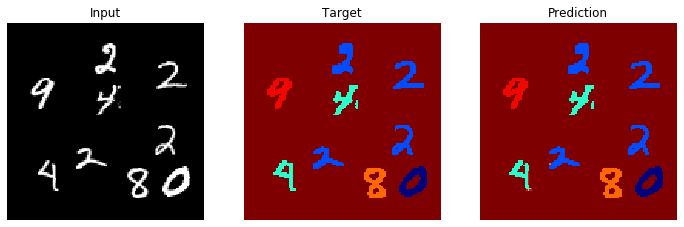

In [12]:
# Test

x,y = next(iter(test_dataloader))
model.eval()
inp = x.unsqueeze(1).to(device)
pred = model(inp)
pred_max = torch.argmax(pred,dim=1)



# Visualize

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,12))
ax1.imshow(x.squeeze(0).cpu(),cmap='gray')
ax1.axis('off')
ax1.set_title('Input')
ax2.imshow(y.squeeze(0).cpu(),cmap='jet')
ax2.axis('off')
ax2.set_title('Target')
ax3.imshow(pred_max.squeeze(0).cpu(),cmap='jet')
ax3.axis('off')
ax3.set_title('Prediction')

In [13]:
# Remove cuda cache

torch.cuda.empty_cache()